<a href="https://colab.research.google.com/github/KathyRoma/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [108]:
# Looking at our data
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [109]:
df.dtypes

Burrito            object
Date               object
Yelp              float64
Google            float64
Chips              object
Cost              float64
Hunger            float64
Mass (g)          float64
Density (g/mL)    float64
Length            float64
Circum            float64
Volume            float64
Tortilla          float64
Temp              float64
Meat              float64
Fillings          float64
Meat:filling      float64
Uniformity        float64
Salsa             float64
Synergy           float64
Wrap              float64
Unreliable         object
NonSD              object
Beef               object
Pico               object
Guac               object
Cheese             object
Fries              object
Sour cream         object
Pork               object
Chicken            object
Shrimp             object
Fish               object
Rice               object
Beans              object
Lettuce            object
Tomato             object
Bell peper         object
Carrots     

In [0]:
import datetime as dt
df['Date'] = df['Date'].astype('datetime64[ns]')

In [111]:
df.dtypes

Burrito                   object
Date              datetime64[ns]
Yelp                     float64
Google                   float64
Chips                     object
Cost                     float64
Hunger                   float64
Mass (g)                 float64
Density (g/mL)           float64
Length                   float64
Circum                   float64
Volume                   float64
Tortilla                 float64
Temp                     float64
Meat                     float64
Fillings                 float64
Meat:filling             float64
Uniformity               float64
Salsa                    float64
Synergy                  float64
Wrap                     float64
Unreliable                object
NonSD                     object
Beef                      object
Pico                      object
Guac                      object
Cheese                    object
Fries                     object
Sour cream                object
Pork                      object
Chicken   

In [0]:
# Train, validate and test split
train = df[df['Date'] <= '2016-12-31']
validate = df[df['Date'].between('2017-01-01', '2017-12-31', inclusive=True)]
test = df[df['Date'] >= '2018-01-01']

In [113]:
validate.head()


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
301,California,2017-01-04,NaN,NaN,NaN,6.60,NaN,NaN,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
302,Other,2017-01-04,NaN,NaN,NaN,6.60,NaN,NaN,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
303,Other,2017-01-07,NaN,NaN,NaN,8.50,3.9,NaN,NaN,21.0,21.0,0.74,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
304,Other,2017-01-07,NaN,NaN,NaN,7.90,4.0,NaN,NaN,20.5,21.0,0.72,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
305,Other,2017-01-10,NaN,NaN,NaN,4.99,3.5,NaN,NaN,18.5,22.5,0.75,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [114]:
validate.shape, train.shape, test.shape

((85, 59), (298, 59), (38, 59))

In [116]:
# Define majority class
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [117]:
y_train.mode()

0    False
dtype: bool

In [118]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
y_pred[:5]

[False, False, False, False, False]

In [119]:
# Check accuracy
from sklearn.metrics import accuracy_score
# Training accuracy of predicting majority class baseline
accuracy_score(y_train, y_pred)

0.5906040268456376

In [120]:
y_validate = validate[target]
y_pred = [majority_class] * len(y_validate)
accuracy_score(y_validate, y_pred)

0.5529411764705883

In [0]:
# STarting with three features
features = ['Cost', 'Google', 'Meat']
X_train = train[features]
X_validate = validate[features]

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_validate_imputed = imputer.transform(X_validate)

In [123]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_validate_imputed, y_validate))

Validation Accuracy 0.7529411764705882


In [124]:
log_reg.predict(X_validate_imputed)

array([ True, False,  True,  True, False, False,  True,  True,  True,
        True,  True, False,  True, False,  True, False, False,  True,
        True,  True,  True, False, False,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
       False, False, False, False,  True, False, False,  True,  True,
        True, False, False,  True, False,  True, False,  True,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True,  True, False,  True,  True,
       False,  True, False, False,  True,  True,  True,  True, False,
        True,  True,  True,  True])

In [0]:
# Let's test if burrito wich costs $5.30 with 3.9 rating on Google and 3.7 point for meat will receive great rating
test_case = [[5.30, 3.9, 3.7]]

In [126]:
# not likely
log_reg.predict_proba(test_case)

array([[0.66771673, 0.33228327]])

In [127]:
log_reg.coef_

array([[0.11225847, 0.74174093, 2.06267934]])

In [128]:
log_reg.intercept_

array([-11.81754927])

In [0]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.e**(-x))

In [130]:
np.dot(log_reg.coef_, np.transpose(test_case))

array([[11.11967309]])

In [131]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.33228327]])

In [132]:
# Let's build a model with 7 features
features = ['Cost', 'Salsa', 'Tortilla', 'Temp', 'Fillings', 'Wrap', 'Meat']
target = 'Great'

X_train = train[features]
y_train = train[target]
X_validate = validate[features]
y_validate = validate[target]

X_train.shape, y_train.shape, X_validate.shape, y_validate.shape

((298, 7), (298,), (85, 7), (85,))

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [134]:
X_train.isnull().sum()

Cost         6
Salsa       20
Tortilla     0
Temp        15
Fillings     1
Wrap         2
Meat        10
dtype: int64

In [0]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_validate_imputed = imputer.transform(X_validate)

In [136]:
X_validate_imputed[:5]

array([[6.6       , 1.5       , 4.        , 4.5       , 3.5       ,
        4.5       , 4.        ],
       [6.6       , 4.2       , 4.        , 2.        , 4.        ,
        5.        , 3.55121528],
       [8.5       , 4.3       , 3.        , 4.5       , 3.        ,
        5.        , 4.1       ],
       [7.9       , 4.        , 3.5       , 4.        , 3.        ,
        4.8       , 4.        ],
       [4.99      , 2.        , 2.5       , 4.5       , 2.5       ,
        4.        , 3.        ]])

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_validate_scaled = scaler.transform(X_validate_imputed)

In [138]:
X_validate_scaled[:5]

array([[-2.47916498e-01, -1.94861062e+00,  6.62698293e-01,
         8.22508165e-01, -2.24469694e-02,  4.69182568e-01,
         5.25949777e-01],
       [-2.47916498e-01,  9.34833702e-01,  6.62698293e-01,
        -1.76842918e+00,  5.67530899e-01,  8.99678662e-01,
        -5.20446908e-16],
       [ 1.33925259e+00,  1.04162794e+00, -5.93162383e-01,
         8.22508165e-01, -6.12424838e-01,  8.99678662e-01,
         6.43144002e-01],
       [ 8.38041299e-01,  7.21245234e-01,  3.47679550e-02,
         3.04320697e-01, -6.12424838e-01,  7.27480225e-01,
         5.25949777e-01],
       [-1.59283346e+00, -1.41463945e+00, -1.22109272e+00,
         8.22508165e-01, -1.20240271e+00,  3.86864734e-02,
        -6.45992473e-01]])

In [139]:
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [140]:
y_pred = model.predict(X_validate_scaled)
accuracy_score(y_validate, y_pred)

0.8352941176470589

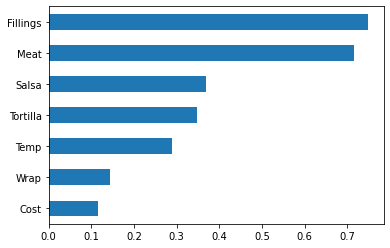

In [141]:
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

In [0]:
# Let's test the model
X_test = test[features]

In [147]:
X_test.head()

,Cost,Salsa,Tortilla,Temp,Fillings,Wrap,Meat
77,8.00,3.0,4.5,5.0,5.0,5.0,5.0
386,7.25,3.0,4.0,5.0,5.0,5.0,4.0
387,4.19,4.0,3.0,5.0,2.0,4.0,2.0
388,7.00,4.0,5.0,5.0,5.0,5.0,5.0
389,8.50,3.0,4.0,4.0,3.5,1.0,3.0


In [146]:
X_test = test[features]
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)
y_pred[:5]

array([ True,  True, False,  True, False])

In [148]:
test.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,2026-04-25,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
386,California,2018-01-02,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
387,Other,2018-01-09,4.5,3.8,NaN,4.19,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,x,NaN,NaN,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,False
388,California,2018-01-12,3.5,4.3,NaN,7.00,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
389,Other,2018-01-12,NaN,NaN,NaN,8.50,4.0,NaN,NaN,21.00,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
